In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import random 
import operator

In [14]:
N=30
nK=3
df={}
for i in range(N):
    df[i,'x']=random.random()
    df[i,'y']=random.random()
df

{(0, 'x'): 0.13139867835390917,
 (0, 'y'): 0.40944163620100027,
 (1, 'x'): 0.52994506065931,
 (1, 'y'): 0.915830963109799,
 (2, 'x'): 0.22657896763880447,
 (2, 'y'): 0.8144757529088789,
 (3, 'x'): 0.021945299471943125,
 (3, 'y'): 0.07554406540688641,
 (4, 'x'): 0.6312515649644852,
 (4, 'y'): 0.8056495357039367,
 (5, 'x'): 0.6612215724502015,
 (5, 'y'): 0.12500474438438702,
 (6, 'x'): 0.03196144978968507,
 (6, 'y'): 0.22408562774227558,
 (7, 'x'): 0.08277754749072974,
 (7, 'y'): 0.3538213499589494,
 (8, 'x'): 0.48679732438749657,
 (8, 'y'): 0.27868510059128127,
 (9, 'x'): 0.4654834660203411,
 (9, 'y'): 0.9995909538876222,
 (10, 'x'): 0.12318053143755336,
 (10, 'y'): 0.450839049196064,
 (11, 'x'): 0.8158758424175854,
 (11, 'y'): 0.2066766797589351,
 (12, 'x'): 0.9557114393929851,
 (12, 'y'): 0.9989844245013703,
 (13, 'x'): 0.681707457769594,
 (13, 'y'): 0.10023209554304346,
 (14, 'x'): 0.21850865624023041,
 (14, 'y'): 0.9233163024733138,
 (15, 'x'): 0.5212718295965314,
 (15, 'y'): 0.4137

In [17]:
n=int(len(df)/2)
model = AbstractModel()
model.N =Param(mutable=True, default=n) 
model.i = RangeSet(1,model.N)
model.k = RangeSet(1,nK)
model.j = Set(initialize=model.i)


model.Alpha = Var(model.k,bounds=(-2,2), within=Reals)
model.Beta = Var(model.k, bounds=(-2,2), within=Reals)


model.U = Var(model.i,model.k, initialize=0,bounds=(0,1), within=Binary)
#model.U = Var(model.i,model.k, bounds=(0,1), within=NonNegativeReals)

model.r = Var(model.i,bounds=(0,200), within=NonNegativeReals)


def rule_C1(model,i,k):
        return model.r[i]>= df[i-1,'x']*model.Alpha[k]+model.Beta[k] -df[i-1,'y'] - 4*(1-model.U[i,k])
model.C1   = Constraint(model.i,model.k,rule=rule_C1)

def rule_C2(model,i,k):
        return model.r[i]>= -(df[i-1,'x']*model.Alpha[k]+model.Beta[k] -df[i-1,'y']) - 4*(1-model.U[i,k])
model.C2   = Constraint(model.i,model.k,rule=rule_C2)

def rule_C7(model,i):
        return sum(model.U[i,k] for k in model.k)==1
model.C7   = Constraint(model.i,rule=rule_C7)

def rule_C8(model,i,k,kk):
        if k!=kk:
            return model.U[i,k] <=1-model.U[i,kk] 
        else:
            return Constraint.Skip
#model.C8   = Constraint(model.i, model.k,model.k,rule=rule_C8)

def rule_C9(model,k):
        if k+1<=nK:
            return model.Alpha[k]<= model.Alpha[k+1]
        else:
            return Constraint.Skip
model.C9   = Constraint(model.k,rule=rule_C9)



def rule_OF(model):
    return sum(model.r[i] for i in model.i)
model.obj1 = Objective(rule=rule_OF, sense=minimize)

In [18]:
opt = SolverFactory('gurobi')
opt.options['mipgap']=0.1
opt.options['ConcurrentMIP']=3
opt.options['Heuristics']=0.1

model.N=n
instance = model.create_instance()

results = opt.solve(instance) # solves and updates instance
print('OF= ',value(instance.obj1))
print ("The solver returned a status of:"+str(results.solver.status))
from pyomo.opt import SolverStatus, TerminationCondition
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
     print ("this is feasible and optimal")
elif results.solver.termination_condition == TerminationCondition.infeasible:
     print ("do something about it? or exit?")
else:
     print (str(results.solver))

OF=  1.524498391065135
The solver returned a status of:ok
this is feasible and optimal


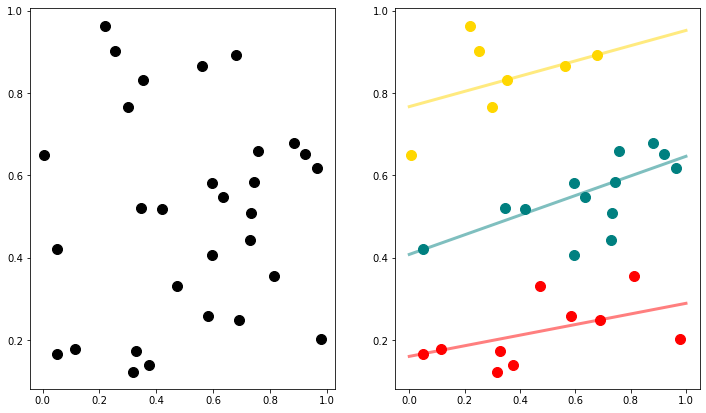

In [19]:
import matplotlib
cname={}
counter=0
for name, hex in matplotlib.colors.cnames.items():
    cname[counter]=hex
    counter+=1
cname=['navy','red','gold','teal','deepskyblue','dodgerblue']    
fig = plt.figure(figsize=(12,7))
plt.subplot(1,2,2)
X=np.linspace(0,1,100)
Y={}

for k in instance.k:
    if sum(value(instance.U[i,k]) for i in instance.i)>0:
        Y[k]=[value(instance.Beta[k]) + value(instance.Alpha[k])*x for x in X]
        plt.plot(X,Y[k],lw=3,alpha=0.5, c=cname[k])    

for i in instance.i:
    for k in instance.k:
        if value(instance.U[i,k])>0:
            plt.scatter(df[i-1,'x'],df[i-1,'y'],label=str(i), s=100,c=cname[k])    

plt.subplot(1,2,1)
for i in instance.i:
    plt.scatter(df[i-1,'x'],df[i-1,'y'],label=str(i), s=100,c='k')    

            
plt.savefig('Multiline RG .png', format='png', bbox_inches='tight', dpi=400)



In [6]:
'''for i in instance.i:
    for k in instance.k:
        #print(i,k, value(instance.r[i]), value(instance.U[i,k]) )
        a=value(sum(df[i-1,'x']*instance.Alpha[k,i]+instance.Beta[k,i] -df[i-1,'y']*instance.U[i,k] for k in instance.k) )
        #b=value(sum(df[i-1,'x']*instance.Alpha[k,i]+instance.Beta[k,i] -df[i-1,'y']*instance.U[i,k] for k in instance.k) )
        b=-value(sum(df[i-1,'x']*instance.Alpha[k,i]+instance.Beta[k,i] -df[i-1,'y']*instance.U[i,k] for k in instance.k) )
        print(i,k,value(instance.r[i]), a,b)

'''

"for i in instance.i:\n    for k in instance.k:\n        #print(i,k, value(instance.r[i]), value(instance.U[i,k]) )\n        a=value(sum(df[i-1,'x']*instance.Alpha[k,i]+instance.Beta[k,i] -df[i-1,'y']*instance.U[i,k] for k in instance.k) )\n        #b=value(sum(df[i-1,'x']*instance.Alpha[k,i]+instance.Beta[k,i] -df[i-1,'y']*instance.U[i,k] for k in instance.k) )\n        b=-value(sum(df[i-1,'x']*instance.Alpha[k,i]+instance.Beta[k,i] -df[i-1,'y']*instance.U[i,k] for k in instance.k) )\n        print(i,k,value(instance.r[i]), a,b)\n\n"

In [7]:
#instance.C8.pprint() 
    

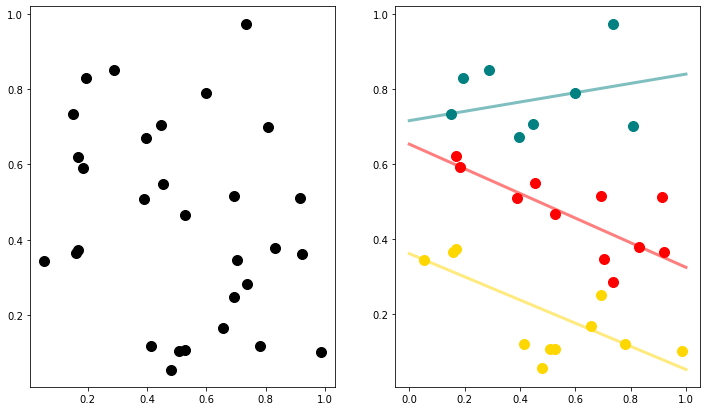

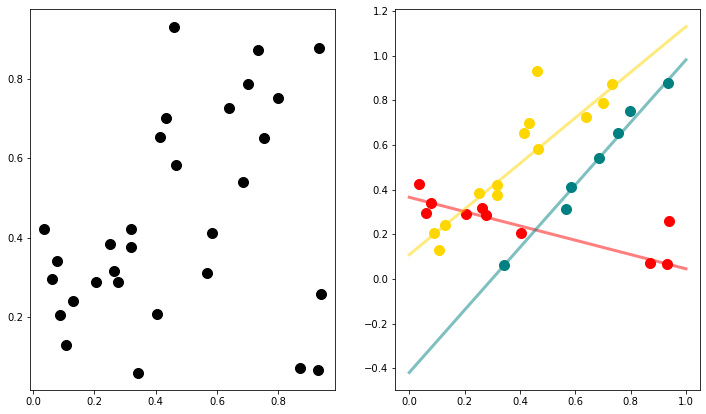

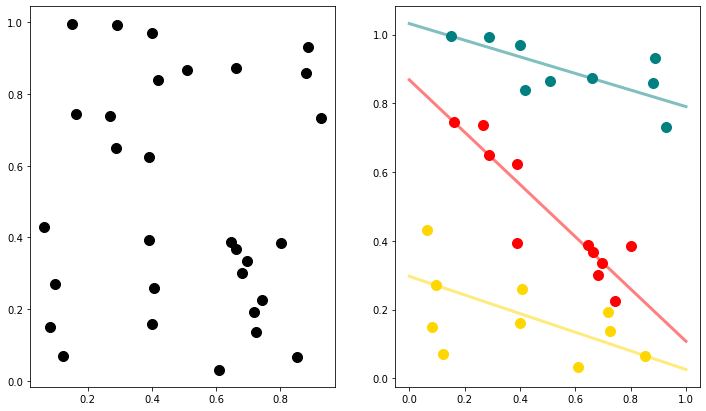

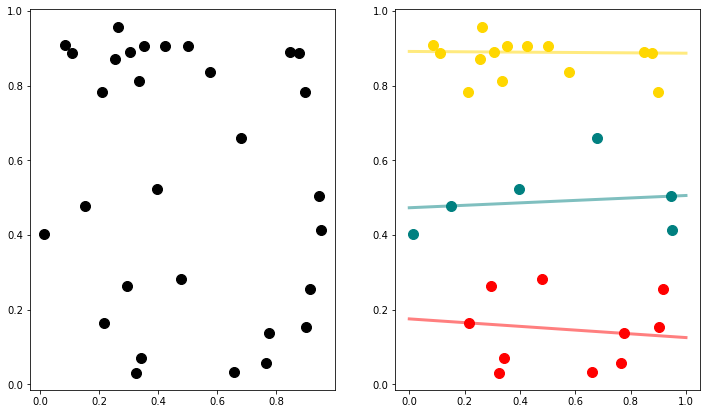

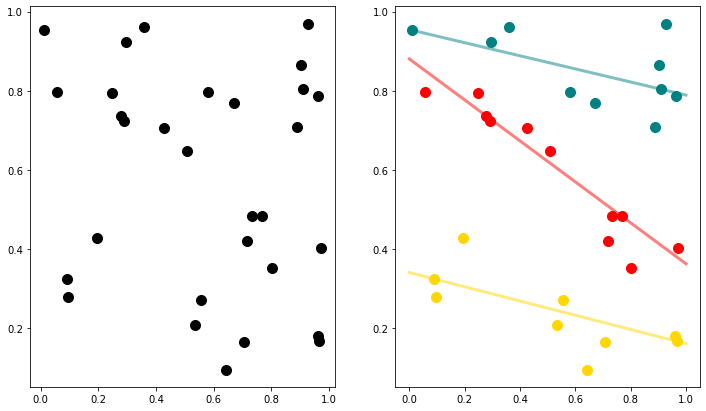

In [20]:
opt = SolverFactory('gurobi')
opt.options['mipgap']=0.1
opt.options['ConcurrentMIP']=3
opt.options['Heuristics']=0.1


for counter in range(5):
    
    for i in range(N):
        df[i,'x']=random.random()
        df[i,'y']=random.random()
    instance = model.create_instance()
    results = opt.solve(instance) # solves and updates instance

    fig = plt.figure(figsize=(12,7))
    plt.subplot(1,2,2)
    X=np.linspace(0,1,100)
    Y={}
    for k in instance.k:
        if sum(value(instance.U[i,k]) for i in instance.i)>0:
            Y[k]=[value(instance.Beta[k]) + value(instance.Alpha[k])*x for x in X]
            plt.plot(X,Y[k],lw=3,alpha=0.5, c=cname[k])    

    for i in instance.i:
        for k in instance.k:
            if value(instance.U[i,k])>0:
                plt.scatter(df[i-1,'x'],df[i-1,'y'],label=str(i), s=100,c=cname[k])    
    plt.subplot(1,2,1)
    for i in instance.i:
        plt.scatter(df[i-1,'x'],df[i-1,'y'],label=str(i), s=100,c='k')    
    plt.savefig('Multiline RG ' + str(counter)+ '.png', format='png', bbox_inches='tight', dpi=400)



    